In [2]:
from __future__ import print_function, division
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import os
import glob
%matplotlib inline

###1. Read the station data downloaded from GHCN archive###
Data obtained from http://www.ncdc.noaa.gov/cdo-web/

In [3]:
def get_date(date_number):
    """
    Turn the int64 value from the DATE of GHCN into a pd.datetime
    """
    dstring = str(date_number)
    return pd.datetime(int(dstring[0:4]),int(dstring[4:6]),int(dstring[6:8]))

def get_df(fnm, var, no_missing = True):
    """
    Create a dataframe for a single station, with a time index, for a single
    variable of data given as a key word (e.g. PRECIP, TMAX, TMIN).
    Requires file path and name (fnm).
    no_missing is a Bool that optionally masks out values < -99 from the df.
    """
    df = pd.read_csv(fnm)
    dt_indx = [get_date(date) for date in df.DATE]
    data_vals = df[var].values
    if var is 'PRCP':
        data_vals = data_vals / 10.  # This is to convert precip data to mm
    if no_missing:
        tmp_df = pd.DataFrame(data=data_vals,
                              index=dt_indx,columns=[df.STATION[0][6:]])
        mask = tmp_df > -99.  # A catchall value for missing data in GHCN
        return tmp_df[mask]
    else:
        return pd.DataFrame(data=data_vals,
                            index=dt_indx,columns=[df.STATION[0][6:]])

def get_combined_df(fpth, var):
    """
    From a given file path, and variable, extract data from all .csv files, and
    place in a single dataframe object.
    """
    flist = glob.glob(fpth)
    df_dic = {}
    for f in flist:
        df_dic[f[5:]] = get_df(fnm = f, var = var, no_missing=True)
    return pd.concat([df_dic[key] for key in df_dic.keys()],axis=1)

Call the Get_combined() function to create dataframes out of all data in a folder.

In [4]:
%%time
df_tmax = get_combined_df(fpth="Data/*.csv",var="TMAX")
df_tmin = get_combined_df(fpth="Data/*.csv",var="TMIN")
df_prcp = get_combined_df(fpth="Data/*.csv",var="PRCP")

CPU times: user 11.3 s, sys: 576 ms, total: 11.9 s
Wall time: 11.7 s


Plot time series of precipitation for all stations, and also accumulate the data and plot the average rainfall.

In [5]:
# Example of masking and accessing data from stations...
#station = df_prcp.keys()[4]
#plt.plot(df_prcp[station].index,df_prcp[station],'.',alpha=0.5)
#plt.title("Station {0:s}".format(station))

In [6]:
#df_prcp.KE000063740['2015']

In [15]:
df_prcp.KE000063740[df_prcp.KE000063740 > 100]

1961-12-27    112.3
1970-04-21    101.9
1980-11-07    311.9
1990-05-09    207.0
1990-05-13    268.0
1991-02-03    193.0
1991-11-17    156.0
1991-11-26    116.0
2001-02-01    182.4
2004-01-14    182.1
2004-05-04    172.2
2005-08-01    180.6
2008-05-31    101.1
2010-02-13    351.5
2011-07-18    135.6
Name: KE000063740, dtype: float64

###2. Time series plots###

Daily Mean and SEM values: Mean uncertainty is given by SEM, where:
SEM=σn

In [16]:
def calc_SEM(data):
    """
    Calculate Standard error of the mean. No nan's 
    should be in the input (numpy) array.
    """
    return np.std(data)/np.sqrt(len(data) - 1)


def gather_daily_stats(date, df):
    """
    For a specified day, given by date, create a short array of 
    observed values (obs) excluding the NANs. Return the mean, 
    and SEM value.
    Restrictions: more than one observation on a day, not a missing
    value, less than 300 mm per day (which is erroneous).
    """
    obs = np.array([df_prcp[key][day] for key in df_prcp.keys()])
    obs = obs[(obs > -1) & (obs < 300)]
    if len(obs) < 2:
        return np.NAN, np.NAN
    return np.mean(obs), calc_SEM(obs)


In [17]:
# Create an accumulated time series (with SEM uncertainty values)
means = []
sems = []
for day in df_prcp.index:
    tmp_mean, tmp_sem = gather_daily_stats(date=day, df=df_prcp)
    means.append(tmp_mean)
    sems.append(tmp_sem)
means = np.array(means)
sems = np.array(sems)
df_prcp['Accumulated']=pd.Series(means,index=df_prcp.index)
df_prcp['Acc_SEM']=pd.Series(sems,index=df_prcp.index)

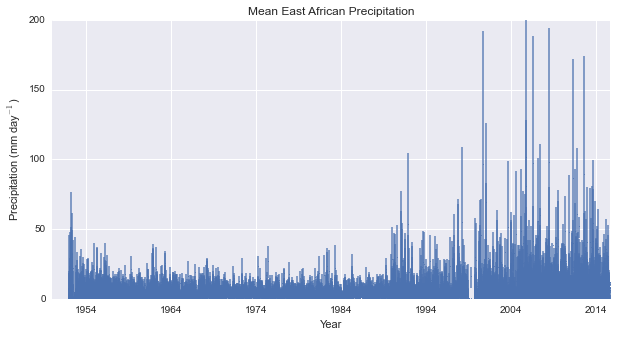

In [28]:
daily_ts = plt.figure(dpi=72)
daily_ts.set_size_inches(10,5)      # Specify the figure size
ax1 = daily_ts.add_subplot(111)     # Add an axis frame object to the plot (i.e. a pannel)

ax1.errorbar(df_prcp.index, df_prcp.Accumulated,
             yerr=df_prcp.Acc_SEM, alpha=0.75, fmt=',')
ax1.set_ylim(0,200)
plt.xlim('1950-01-01','2015-08-31')
plt.title("Mean East African Precipitation")
plt.ylabel("Precipitation (mm day$^{-1}$)")
plt.xlabel("Year")
plt.grid(True)
plt.show(daily_ts)

In [10]:
import seaborn as sns

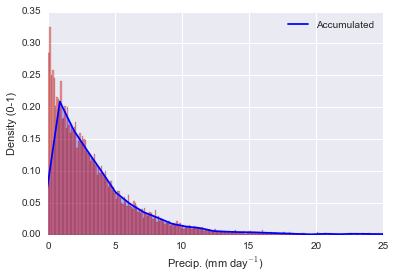

In [22]:
# N.b. the KDE (kernel density estimate) is Gaussian - which is not true
# for precip data (log or power law data)...
mask = df_prcp.Accumulated > 0.0
sns.distplot(df_prcp.Accumulated[mask],bins=1000, norm_hist = True,
             kde=False,color = 'r')
sns.kdeplot(df_prcp.Accumulated[mask],shade=True,kernel='cos',cumulative=False,color='b')
plt.xlim(0,25)#max(df_prcp.Accumulated))
plt.xlabel('Precip. (mm day$^{-1}$)')
plt.ylabel('Density (0-1)')

In [24]:
sns.kdeplot # Hot tip - look in SEABORN for statistical plots and help...

<function seaborn.distributions.kdeplot>

Tasks:
1. find out why the later part of the data has high variability
2. make sure you are happy/add any logical restrictions to improve the data quality in Accumulated dataset
3. Caclulate population statistics, histrogram, density plots (PDF, CDF), and fits to the population. Try several fit approaches, and show which is best.
4. Use the CDF (or a percentile function) to determine the key (IQR, median, tails etc) of the population
5. (hard) try to fit to the population. Reccomend trying a nth order polyfit using np.polyfit()

###3. Seasonality###

Calculate the DOY mean over the data-period (climatology).

In [25]:
doy_mean=[]
doy_sem =[]
doy_csum=[]
for doy in range(366):
    index = df_prcp.index.dayofyear == doy+1 
    doy_mean.append(np.nanmean(df_prcp[index]))
    doy_sem.append(np.nanstd(df_prcp[index])/np.sqrt(len(df_prcp[index])-1))  

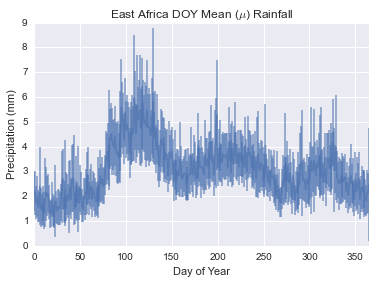

In [26]:
plt.errorbar(range(366),doy_mean,xerr=None, yerr=doy_sem, alpha=0.6)
plt.xlim(0,max(range(366)))
plt.title("East Africa DOY Mean ($\mu$) Rainfall")
plt.ylabel("Precipitation (mm)")
plt.xlabel("Day of Year")

Anomaly

Use the seasonal DOY mean to calculate deviations (anomaly) from the daily mean

In [ ]:
##Anomalies = Observation - Climatology
anomalies = []
for n,day in enumerate(df_prcp.index):
    #print("Index: {0} Date: {1} Value: {0:3.3f}".format(n,df_prcp.index[n].date(),day[0]))
    doyi = df_prcp.index[n].dayofyear -1 # Create an index to call doy_mean
    #print(n, doy_mean[doyi])
    anomalies.append(day - doy_mean[doyi])


Correlation Matrix

In [14]:
corr_matrix = df_prcp
corr_matrix.corr(method='pearson', min_periods=1)

,ET000063331,KEM00063799,ET000063402,KE000063661,KE000063740,KE000063612,KEM00063741,ET000063450,ET000063471,TZ000063894,...,KE000063619,TZ000063756,SU000062941,KEM00063686,KE000063820,RWM00064387,KE000063723,KE000063624,Accumulated,Acc_SEM
ET000063331,1.000000,0.013189,0.137541,0.027972,-0.048330,-0.004076,-0.089968,0.165515,0.090720,-0.037489,...,NaN,-0.079837,0.069454,0.072099,0.003577,-0.026476,-0.027603,-0.038117,0.329573,0.285331
KEM00063799,0.013189,1.000000,0.027534,0.013107,0.017628,0.029739,0.058509,0.014750,0.025589,0.095574,...,NaN,0.008945,0.044520,0.037598,0.190247,0.010053,0.022872,0.036502,0.352587,0.346703
ET000063402,0.137541,0.027534,1.000000,0.027246,-0.031112,0.027558,-0.012083,0.142761,0.084465,-0.011826,...,NaN,-0.023525,0.101591,0.078284,0.030423,-0.020223,-0.017723,0.022280,0.422647,0.355877
KE000063661,0.027972,0.013107,0.027246,1.000000,0.039609,0.054337,0.108188,0.038700,0.043580,0.039754,...,NaN,0.076275,0.023899,0.144486,0.011645,0.020585,0.018957,0.035945,0.303294,0.256975
KE000063740,-0.048330,0.017628,-0.031112,0.039609,1.000000,0.030429,0.197129,-0.031661,0.017088,0.079381,...,NaN,0.123871,0.000796,0.085107,0.056486,0.015104,0.117653,0.055069,0.384716,0.349653
KE000063612,-0.004076,0.029739,0.027558,0.054337,0.030429,1.000000,0.029413,0.008072,0.005231,0.016282,...,NaN,0.039412,0.000541,0.091737,0.021765,0.010813,0.027103,0.016131,0.390309,0.369417
KEM00063741,-0.089968,0.058509,-0.012083,0.108188,0.197129,0.029413,1.000000,-0.045662,0.061123,0.075006,...,NaN,0.084568,0.021385,0.116994,0.068244,0.003379,0.048197,0.042733,0.399289,0.371268
ET000063450,0.165515,0.014750,0.142761,0.038700,-0.031661,0.008072,-0.045662,1.000000,0.153815,-0.022080,...,NaN,-0.033686,0.067576,0.077284,-0.004109,-0.008122,-0.015818,0.015591,0.320959,0.282737
ET000063471,0.090720,0.025589,0.084465,0.043580,0.017088,0.005231,0.061123,0.153815,1.000000,0.038692,...,NaN,0.011082,0.036199,0.041549,0.028561,0.045536,0.023914,0.044875,0.331286,0.275352
TZ000063894,-0.037489,0.095574,-0.011826,0.039754,0.079381,0.016282,0.075006,-0.022080,0.038692,1.000000,...,NaN,0.049258,-0.002515,0.022086,0.114124,0.021807,0.047445,0.051279,0.418411,0.434256


calculate the percentiles

In [15]:
def percentile(df, percentile):
   # size = len(df_prcp)
     
    p90 = []
    p95 = []
    p99 = [] 
    for day in df_prcp.index:
        tmp = np.array([df_prcp[key][day] for key in df_prcp.keys()])
        p90.append(np.percentile(tmp,90))    # ...find the nth percentile uncertainty values 
        p95.append(np.percentile(tmp,95)) 
        p99.append(np.percentile(tmp,99)) 
        
        
        return p90, p95, p99

In [16]:
#from scipy.stats import scoreatpercentile
# percentiles of interest
#tmp = np.array([df_prcp[key][day] for key in df_prcp.keys()])
#perc = [min(tmp), scoreatpercentile(tmp,10), scoreatpercentile(tmp,25),
              # scoreatpercentile(tmp,50), scoreatpercentile(tmp,75),
               #scoreatpercentile(tmp,90), max(tmp)]

In [17]:
a = [154, 400, 1124, 82, 94, 108]
print (np.percentile(a,95)) # gives the 95th percentile

943.0
